---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict
from collections import deque
import time

In [2]:
class Exercise:
    def __init__(self, schema = 1):
        # Figure settings
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(-100, 100)
        self.ax.set_title('Map of cities')
        self.ax.set_xlabel("X coordinate")
        self.ax.set_ylabel("Y coordinate")
        self.ax.set_aspect("equal")
        self.ax.grid(True, linestyle="--", alpha=0.5)
        
        # Poland map:
        poland_outline = [
            (-25, 90), # Gorna czesc
            (-90, 70), # lewa gorna czesc
            (-75, -30), # lewa dolna czesc
            (-20, -80), # dolna czesc
            (70, -90), # dolna czesc po prawej
            (90, -50), #
            (80, 0), 
            (85, 30),
            (75, 80),
            (0, 85),
            (-15, 80),
            (-25, 90)
        ]

        # Prepared points for matplotlib plot of poland map 
        poland_x = [point[0] for point in poland_outline]
        poland_y = [point[1] for point in poland_outline]

        # Schema settings
        if schema != 3:
            self.ax.plot(poland_x, poland_y, color='r')


        self.schemas = {
            1: self.schema_1(),
            2: self.schema_2(),
            3: self.schema_3()
        }

        if schema not in self.schemas:
            raise ValueError("Values only [1,2 and 3]")
        
        self.cities, self.connections = self.schemas[schema]
        self.graph = self.create_graph()
        self.distance_matrix = self.adjacency_matrix(cities=self.cities, connections= self.connections)
        self.plot_cities()

    def poland_cities(self):
        cities = {
            "Poznań": (-30, 15),
            "Warszawa": (55, 10),
            "Łódź": (10, -25),
            "Gdańsk": (-15, 80),
            "Lublin": (60, -40),
            "Kraków": (25, -75),
            "Szczecin": (-80, 60),
            "Wrocław": (-50, -25),
            "Toruń": (15, 40),
            "Katowice": (-10, -60)
        }

        return cities
    
    def poland_connections(self):
        connections = {
            "Poznań": ["Szczecin", "Wrocław", "Gdańsk", "Toruń", "Łódź", "Warszawa"],
            "Szczecin": ["Gdańsk", "Poznań", "Wrocław", "Toruń"],
            "Wrocław": ["Poznań", "Szczecin", "Łódź", "Kraków", "Katowice"],
            "Łódź": ["Wrocław", "Poznań", "Toruń", "Warszawa", "Lublin", "Kraków", "Katowice"],
            "Kraków": ["Wrocław", "Łódź", "Lublin", "Katowice"],
            "Lublin": ["Kraków", "Łódź", "Warszawa"],
            "Warszawa": ["Poznań", "Toruń", "Lublin", "Łódź"],
            "Toruń": ["Gdańsk", "Szczecin", "Poznań", "Łódź", "Warszawa"],
            "Gdańsk": ["Szczecin", "Poznań", "Toruń"],
            "Katowice": ["Kraków", "Łódź", "Wrocław"]
        }
        return connections

    def schema_1(self):
        cities = self.poland_cities()
        
        connections = self.poland_connections()
        
        return cities, connections
    
    def schema_2(self):
        # Random cities with connections to each other
        cities = self.poland_cities()

        city_names = list(cities.keys())
        connections = defaultdict()

        for city_name in city_names:
            connections[city_name] = [city for city in city_names if city != city_name]

        return cities, connections

    def schema_3(self, num_cities=5, connection_prob=0.8):
        # Random cities with random connections
        cities = {}
        for i in range(1, num_cities+1):
            city_name = f"City {i}"
            cities[city_name] = tuple(np.random.uniform(-100, 100, size=2).round(1))
        
        connections = defaultdict(list)
        city_list = list(cities.keys())
        existing_connections = set()

        for i in range(len(city_list)):
            for j in range(i+1, len(city_list)):
                city_a, city_b = city_list[i], city_list[j]
                connection_key = frozenset({city_a, city_b})
                
                if connection_key not in existing_connections and np.random.random() < connection_prob:
                    connections[city_a].append(city_b)
                    connections[city_b].append(city_a)
                    existing_connections.add(connection_key)

        # Checking if there is a city with no connections
        for city in city_list:
            if not connections[city]:
                closest = None
                min_dist = float()
                for other in city_list:
                    if other != city:
                        dist = math.dist(cities[city], cities[other])
                        if dist < min_dist:
                            min_dist = dist
                            closest = other
                if closest:
                    connection_key = frozenset({city, closest})
                    if connection_key not in existing_connections:
                        connections[city].append(closest)
                        connections[closest].append(city)
                        existing_connections.add(connection_key)
        
        return cities, connections
   
    def euclidean_distance(self, city1, city2):
        # Distance between cities
        x1, y1 = self.cities[city1]
        x2, y2 = self.cities[city2]
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    def path_distance(self, path):
        # distance of the whole path
        distance = 0
        for i in range(len(path-1)):
            current = path[i]
            next_city = path[i + 1]

    def create_graph(self):
        graph = {
            'nodes': set(self.cities.keys()),
            'edges': defaultdict(list)
        }

        connections_drawn = set()

        for city, neighbors in self.connections.items():
            for neighbor in neighbors:

                connection_key = frozenset({city, neighbor}) # Funkcja ktora daje unikalny set, gdzie (A, B) = (B, A), nie jest wazna kolejnosc, alternatywa tuple(sorted())
                
                if connection_key not in connections_drawn:
                    distance = self.euclidean_distance(city, neighbor)

                    graph['edges'][city].append((neighbor, distance))
                    graph['edges'][neighbor].append((city, distance))
                    connections_drawn.add(connection_key)

        return graph

    def plot_cities(self):
        for city_name, (x, y) in self.cities.items():
            self.ax.scatter(x, y, label=city_name, color='b', zorder=5)
            self.ax.text(x-10, y+5, city_name, fontsize=9, color='black')

        connections_drawn = set()

        for city, neighbors in self.connections.items():
            x1, y1 = self.cities[city]
            for neighbor in neighbors:
                x2, y2 = self.cities[neighbor]

                key = tuple(sorted([city, neighbor]))
                if key not in connections_drawn:
                    self.ax.plot([x1, x2], [y1, y2], color='gray', zorder = 2, alpha=0.5)
                    
                    mid_x = (x1 + x2) // 2
                    mid_y = (y1 + y2) // 2

                    distance = next((dist for (n, dist) in self.graph['edges'][city] if n == neighbor), 0)
                    
                    
                    self.ax.text(mid_x, mid_y, f"{distance:.1f}", 
                                fontsize=8, color='darkgreen')
                    
                    connections_drawn.add(key)

    def DFS(self, start_city):
        # DFS Like checking one possible option until it's the correct one - first correct wins
        if start_city not in self.cities:
                raise ValueError("Start city not found in the map")
        
        stack = []
        stack.append((start_city, 0, [start_city]))

        while len(stack) > 0:
            current_city, total_distance, path = stack.pop()

            if len(path) == len(self.cities) and start_city in self.connections[current_city]:
                return path + [start_city], total_distance + self.euclidean_distance(current_city, start_city)
            
            for neighbor in self.connections[current_city]:
                if neighbor not in path:
                    new_path = path + [neighbor]
                    new_distance = total_distance + self.euclidean_distance(current_city, neighbor)
                    stack.append((neighbor, new_distance, new_path))

    def BFS(self, start_city):
        # BFS Like checking all possible options
        if start_city not in self.cities:
                raise ValueError("Start city not found in the map")
        
        queue = deque()
        queue.append((start_city, 0, [start_city])) # First state

        results = [] # Results

        while len(queue) > 0:
            current_city, total_distance, path = queue.popleft() # current state

            if len(path) == len(self.cities):
                if start_city in self.connections[current_city]:
                    results.append((start_city, total_distance + self.euclidean_distance(current_city, start_city), path + [start_city]))
                continue

            # Creating another states
            for neighbor in self.connections[current_city]: 
                if neighbor not in path:
                    new_path = path + [neighbor]
                    new_distance = total_distance + self.euclidean_distance(current_city, neighbor)
                    queue.append((neighbor, new_distance, new_path))

        best_path = min(results, key=lambda x: x[1]) # Taking best path based on total distance
        return best_path[2], best_path[1]

    def greedy_tsp(self, start_city):
        if start_city not in self.cities:
            raise ValueError("Start city not found in the map")
        
        visited = set()
        path = [start_city]
        visited.add(start_city)
        total_distance = 0

        current_city = start_city

        # Goal to visit all cities
        while len(visited) < len(self.cities):
            # For each city
            nearest_city = None
            min_distance = float('inf')

            # Check every neighbor of the current city for his neighbours and distances
            for neighbor, distance in self.graph['edges'][current_city]:
                if neighbor not in visited and distance < min_distance:
                    min_distance = distance
                    nearest_city = neighbor

            # No connections
            if nearest_city is None:
                break

            path.append(nearest_city)
            visited.add(nearest_city)
            total_distance += min_distance
            current_city = nearest_city

        # After all visited cities, we search return way
        if current_city in self.connections.get(start_city):
            return_distance = self.euclidean_distance(current_city, start_city)
            total_distance += return_distance
            path.append(start_city)
        else:
            print("No direct connection to start city")

        return path, total_distance

    def minimum_spanning_tree(self, start_city):
        if start_city not in self.cities:
            raise ValueError("Start city not found in the map")
        
        visited = set()
        visited.add(start_city)
        edges = []
        total_distance = 0

        while len(visited) < len(self.cities):
            min_edge = None
            min_distance = float('inf')

            for city in visited:
                for neighbor, distance in self.graph['edges'][city]:
                    if neighbor not in visited and distance < min_distance:
                        min_edge = (city, neighbor)
                        min_distance = distance
            
            if min_edge:
                from_city, to_city = min_edge
                visited.add(to_city)
                edges.append((from_city, to_city, distance))
                total_distance += min_distance

        return edges, total_distance
     
    def adjacency_matrix(self, cities, connections):
        city_names = cities.keys()

        matrix = []

        for city_a in city_names:
            city_matrix = []
            for city_b in city_names:
                if city_b in connections[city_a]:
                    city_matrix.append(round(self.euclidean_distance(city_a, city_b)))
                else:
                    if city_a == city_b:
                        city_matrix.append(0)
                    else:
                        city_matrix.append(float('inf'))
            matrix.append(city_matrix)

        return matrix

    def plot_path(self, path, color='blue', linestyle='-', linewidth=2):
        for i in range(len(path)-1):
            city1 = path[i]
            city2 = path[i+1]
            x1, y1 = self.cities[city1]
            x2, y2 = self.cities[city2]
            self.ax.plot([x1, x2], [y1, y2], color=color, 
                        linestyle=linestyle, linewidth=linewidth, zorder=3)
            
    def plot_path_tree(self, edges, color='green', linestyle='-', linewidth=2):
        for from_city, to_city, _ in edges:
            x1, y1 = self.cities[from_city]
            x2, y2 = self.cities[to_city]
            self.ax.plot([x1,x2], [y1,y2], color=color, 
                         linestyle=linestyle, linewidth=linewidth, zorder=3)


---

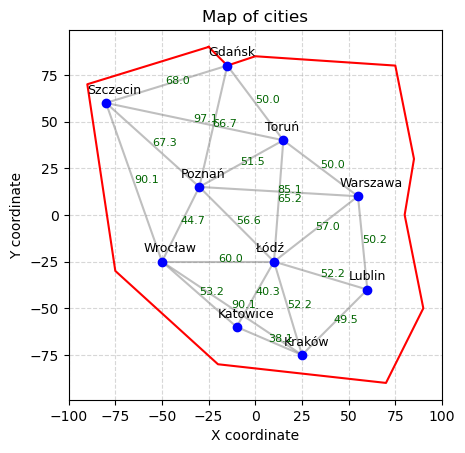

In [3]:
schema_1=Exercise(schema=1)
plt.show()

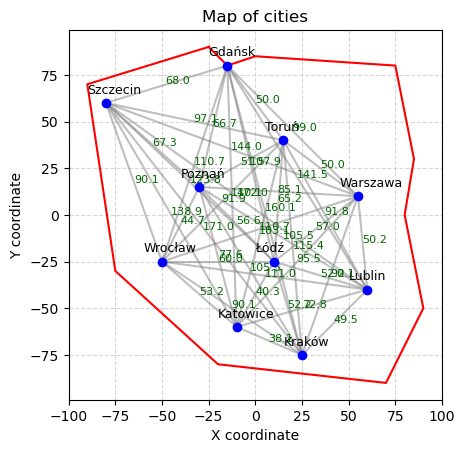

In [4]:
schema_2 = Exercise(schema=2)
plt.show()

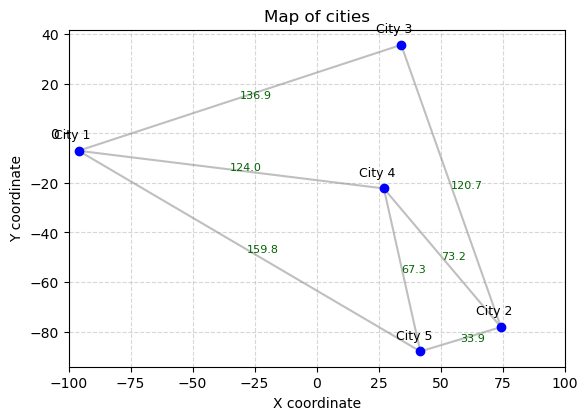

In [5]:
schema_3 = Exercise(schema=3)

---

## Gready:

Gdańsk -> Toruń -> Warszawa -> Lublin -> Kraków -> Katowice -> Łódź -> Poznań -> Wrocław -> Szczecin -> Gdańsk
Total distance: 537.57km
Total time: 0.02s


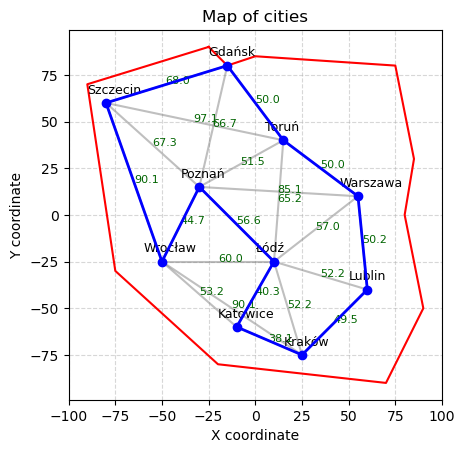

In [6]:
start = time.time()
schema_1 = Exercise(schema=1)
path, distance = schema_1.greedy_tsp("Gdańsk")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_1.plot_path(path=path)
plt.show()


Gdańsk -> Toruń -> Warszawa -> Lublin -> Kraków -> Katowice -> Łódź -> Poznań -> Wrocław -> Szczecin -> Gdańsk
Total distance: 537.57km
Total time: 0.02s


[]

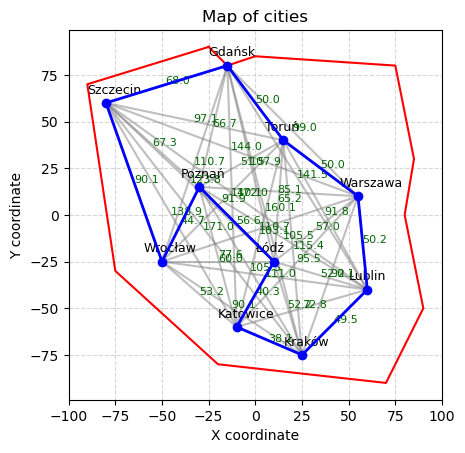

In [7]:
start = time.time()
schema_2 = Exercise(schema=2)
path, distance = schema_2.greedy_tsp("Gdańsk")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_2.plot_path(path=path)
plt.plot()

No direct connection to start city
City 1 -> City 5 -> City 2 -> City 3 -> City 4
Total distance: 439.21km
Total time: 0.01s


[]

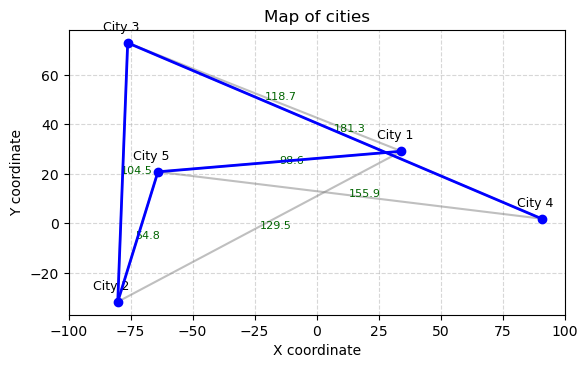

In [8]:
start = time.time()
schema_3 = Exercise(schema=3)
path, distance = schema_3.greedy_tsp("City 1")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_3.plot_path(path=path)
plt.plot()

---

## BFS

Gdańsk -> Szczecin -> Poznań -> Wrocław -> Łódź -> Katowice -> Kraków -> Lublin -> Warszawa -> Toruń -> Gdańsk
Total distance: 518.13km
Total time: 0.02s


[]

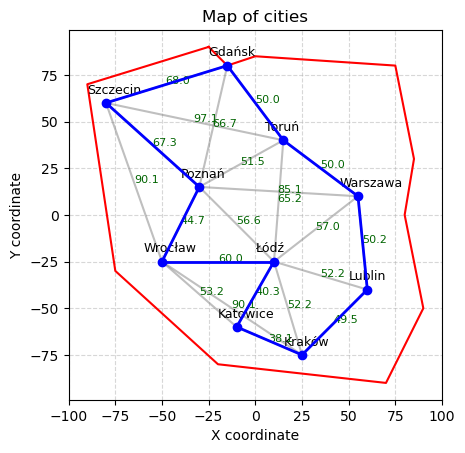

In [9]:
start = time.time()
schema_1 = Exercise(schema=1)
path, distance = schema_1.BFS("Gdańsk")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_1.plot_path(path=path)
plt.plot()

Gdańsk -> Szczecin -> Poznań -> Wrocław -> Łódź -> Katowice -> Kraków -> Lublin -> Warszawa -> Toruń -> Gdańsk
Total distance: 518.13km
Total time: 0.96s


[]

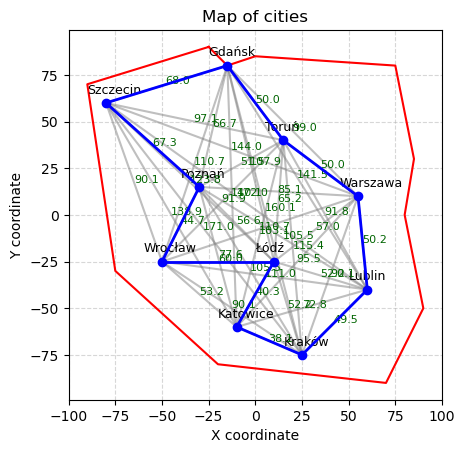

In [10]:
start = time.time()
schema_2 = Exercise(schema=2)
path, distance = schema_2.BFS("Gdańsk")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_2.plot_path(path=path)
plt.plot()

City 1 -> City 3 -> City 5 -> City 2 -> City 4 -> City 1
Total distance: 573.76km
Total time: 0.01s


[]

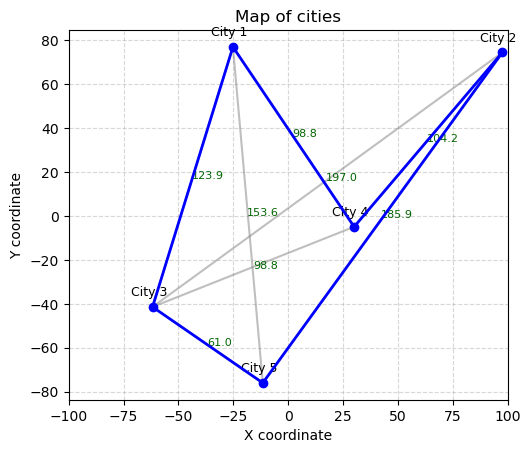

In [11]:
start = time.time()
schema_3 = Exercise(schema=3)
path, distance = schema_3.BFS("City 1")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_3.plot_path(path=path)
plt.plot()

---

## DFS

Gdańsk -> Toruń -> Warszawa -> Łódź -> Lublin -> Kraków -> Katowice -> Wrocław -> Szczecin -> Poznań -> Gdańsk
Total distance: 574.05km
Total time: 0.04s


[]

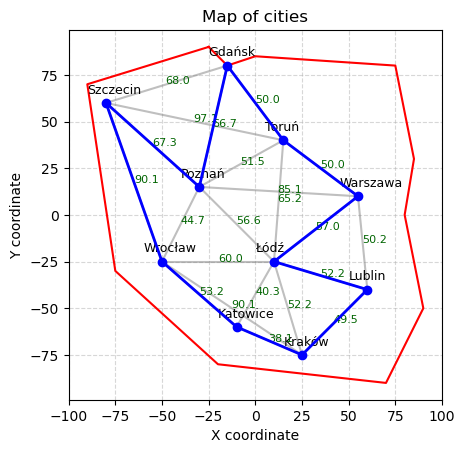

In [12]:
start = time.time()
schema_1 = Exercise(schema=1)
path, distance = schema_1.DFS("Gdańsk")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_1.plot_path(path=path)
plt.plot()

Gdańsk -> Katowice -> Toruń -> Wrocław -> Szczecin -> Kraków -> Lublin -> Łódź -> Warszawa -> Poznań -> Gdańsk
Total distance: 906.82km
Total time: 0.02s


[]

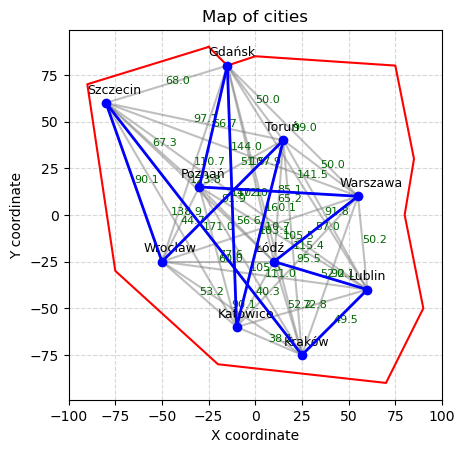

In [13]:
start = time.time()
schema_2 = Exercise(schema=2)
path, distance = schema_2.DFS("Gdańsk")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_2.plot_path(path=path)
plt.plot()

City 1 -> City 5 -> City 4 -> City 2 -> City 3 -> City 1
Total distance: 656.19km
Total time: 0.01s


[]

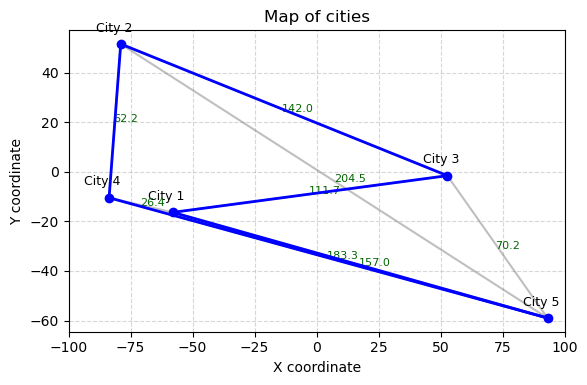

In [14]:
start = time.time()
schema_3 = Exercise(schema=3)
path, distance = schema_3.DFS("City 1")
end = time.time()
print(" -> ".join(path))
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_3.plot_path(path=path)
plt.plot()

---

## Minimum Spanning tree

Total distance: 441.60km
Total time: 0.02s


[]

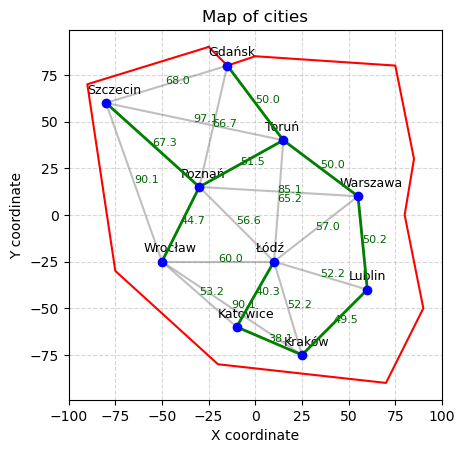

In [15]:
start = time.time()
schema_1 = Exercise(schema=1)
edges, distance = schema_1.minimum_spanning_tree("Gdańsk")
end = time.time()
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_1.plot_path_tree(edges=edges)
plt.plot()

Total distance: 441.60km
Total time: 0.02s


[]

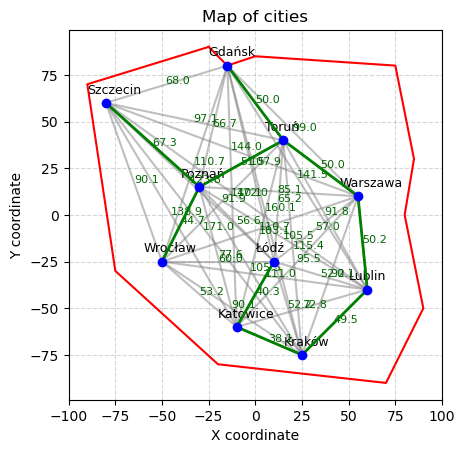

In [16]:
start = time.time()
schema_2 = Exercise(schema=2)
edges, distance = schema_2.minimum_spanning_tree("Gdańsk")
end = time.time()
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_2.plot_path_tree(edges=edges)
plt.plot()

Total distance: 328.69km
Total time: 0.01s


[]

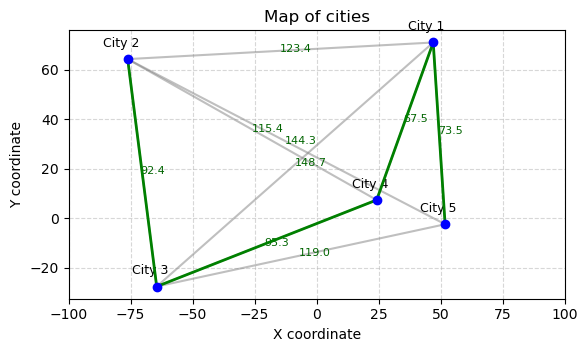

In [17]:
start = time.time()
schema_3 = Exercise(schema=3)
edges, distance = schema_3.minimum_spanning_tree("City 1")
end = time.time()
print(f"Total distance: {distance:.2f}km")
print(f"Total time: {end-start:.2f}s")
schema_3.plot_path_tree(edges=edges)
plt.plot()

---

testing functions etc

In [18]:
schema_1_graph = schema_1.graph

In [19]:
cities = {
    "Poznań": (-30, 15),
    "Warszawa": (55, 10),
    "Łódź": (10, -25),
    "Gdańsk": (-15, 80),
    "Lublin": (60, -40),
    "Kraków": (25, -75),
    "Szczecin": (-80, 60),
    "Wrocław": (-50, -25),
    "Toruń": (15, 40)
}



visited = set()
visited.add("Gdańsk")
path = ["Gdańsk"]
edges = []
total_distance = 0

while len(visited) < len(cities):
    min_edge = None # connection between cities
    min_distance = float('inf')

    for city in visited:
        for neighbor, distance in schema_1_graph['edges'][city]:
            if neighbor not in visited and distance < min_distance:
                min_edge = (city, neighbor)
                min_distance = distance

    if min_edge:
        from_city, to_city = min_edge
        visited.add(to_city)
        edges.append((from_city, to_city, min_distance))
        total_distance += min_distance 

edges

[('Gdańsk', 'Toruń', 50.0),
 ('Toruń', 'Warszawa', 50.0),
 ('Warszawa', 'Lublin', 50.24937810560445),
 ('Lublin', 'Kraków', 49.49747468305833),
 ('Kraków', 'Katowice', 38.07886552931954),
 ('Katowice', 'Łódź', 40.311288741492746),
 ('Toruń', 'Poznań', 51.478150704935004),
 ('Poznań', 'Wrocław', 44.721359549995796)]

In [20]:
schema_1_graph['edges']['Gdańsk']

[('Poznań', 66.70832032063167),
 ('Szczecin', 68.00735254367721),
 ('Toruń', 50.0)]

In [21]:
cities = {
    "Poznań": (-30, 15),
    "Warszawa": (55, 10),
    "Łódź": (10, -25),
    "Gdańsk": (-15, 80),
    "Lublin": (60, -40),
    "Kraków": (25, -75),
    "Szczecin": (-80, 60),
    "Wrocław": (-50, -25),
    "Toruń": (15, 40)
}

city_names = list(cities.keys())
connections = defaultdict()

for city_name in city_names:
    connections[city_name] = [city for city in city_names if city != city_name]

connections

defaultdict(None,
            {'Poznań': ['Warszawa',
              'Łódź',
              'Gdańsk',
              'Lublin',
              'Kraków',
              'Szczecin',
              'Wrocław',
              'Toruń'],
             'Warszawa': ['Poznań',
              'Łódź',
              'Gdańsk',
              'Lublin',
              'Kraków',
              'Szczecin',
              'Wrocław',
              'Toruń'],
             'Łódź': ['Poznań',
              'Warszawa',
              'Gdańsk',
              'Lublin',
              'Kraków',
              'Szczecin',
              'Wrocław',
              'Toruń'],
             'Gdańsk': ['Poznań',
              'Warszawa',
              'Łódź',
              'Lublin',
              'Kraków',
              'Szczecin',
              'Wrocław',
              'Toruń'],
             'Lublin': ['Poznań',
              'Warszawa',
              'Łódź',
              'Gdańsk',
              'Kraków',
              'Szczecin',
      

In [22]:
math.sqrt((53-66)**2 + (-65-92)**2)

157.53729717117784

In [23]:
def euclidean_distance(city1, city2):
    # Distance between cities
    x1, y1 = city1
    x2, y2 = city2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

cities = {
    "Poznań": (-30, 15),
    "Warszawa": (55, 10),
    "Łódź": (10, -25),
    "Gdańsk": (-15, 80),
    "Lublin": (60, -40),
    "Kraków": (25, -75),
    "Szczecin": (-80, 60),
    "Wrocław": (-50, -25),
    "Toruń": (15, 40)
}

city_names = list(cities.keys())
connections = defaultdict()

for city_name in city_names:
    connections[city_name] = [city for city in city_names if city != city_name]

adjacency_matrix = []

# For all conecctions
for city_a in city_names:
    adjacency_matrix.append([euclidean_distance(cities[city_a], cities[city_b]) for city_b in city_names])
